# main.ipynb with transfer learning implemented


This notebook takes a pretrained network (in the form of a hdf5 file) and performs some variation of transfer learning. As currently implemented, a network trained on aluminum is taken, and trained on platinum. 

The transfer learning method is a bit unorthodox. A more detailed explanation is included in the word doc. First, the expanding path of the aluminum network is trained for 20 epochs with lr = 1e-4 on the platinum data. Weights and biases are not reinitialized. Then, the whole network is trained for 10 epochs with lr = 5e-6 (step referred to as fine tuning throughout the rest of the documentation)

# Setting up Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Lab/Grain-U-Net'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))
sys.path.append('/content/drive/MyDrive/{}/src'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

!pip install -q plantcv
!pip install -e .

Mounted at /content/drive
/content/drive/My Drive/Lab/Grain-U-Net
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/My%20Drive/Lab/Grain-U-Net
  Attempting uninstall: src
    Found existing installation: src 0.0.0
    Can't uninstall 'src'. No files were found to uninstall.
  Running setup.py develop for src


In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -tensorflow


# Train on Aluminum

This is for training the network on aluminum. This step can be skipped if you already have a pretrained aluminum network, simply import at the next section

In [ ]:
from pathlib import Path
import numpy as np

train_dir = Path('data/train_nouveaux_256')

input_names = list(train_dir.glob('*/image/*.png'))
label_names = list(train_dir.glob('*/label/*.png'))

print(f"Found {len(input_names)} samples and {len(label_names)} tracings")

Found 299 samples and 299 tracings


In [ ]:
from src import GrainSequence
import random

validation_samples = len(input_names) // 10
batch_size = 5

random.Random(1337).shuffle(input_names)
random.Random(1337).shuffle(label_names)

train_input = input_names[:-validation_samples]
train_label = label_names[:-validation_samples]
train_gen = GrainSequence(batch_size, (256,256), train_input, train_label)

valid_input = input_names[-validation_samples:]
valid_label = label_names[-validation_samples:]
valid_gen = GrainSequence(batch_size, (256,256), valid_input, valid_label)

print(f"Training set size: {len(train_input)}, {len(train_gen)} batches")
print(f"Validation set size: {len(valid_input)}, {len(valid_gen)} batches")

if False:
    _ = [print(f'{ind}:\n{i}\n{l}\n\n') for ind, (i, l) in enumerate(zip(train_input, train_label))]

SyntaxError: ignored

In [ ]:
from src import get_unet
from tensorflow import keras

model = get_unet(input_size = (256, 256, 1))       ###change to dice
model_checkpoint = keras.callbacks.ModelCheckpoint('unet_grain_nouveaux_posttune.hdf5', monitor='loss', verbose=1, save_best_only=False)
history = model.fit(
    train_gen, 
    steps_per_epoch=len(train_gen), 
    epochs=30, 
    callbacks=[model_checkpoint], 
     validation_data=valid_gen
)

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

plt.figure(figsize=(10,5), facecolor='White')

plt.title("Loss With Pre Augmentation and Full Dataset (b5, s59)")
plt.xlabel("Epochs")
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.legend()
plt.show()

# Transfer onto pt data

**Importing Pt data as sequence**

In [ ]:
from pathlib import Path
import numpy as np

train_dir = Path('data/train_Pt_16')

input_names = list(train_dir.glob('*/image/*.png'))
label_names = list(train_dir.glob('*/label/*.png'))

print(f"Found {len(input_names)} samples and {len(label_names)} tracings")

Found 160 samples and 160 tracings


In [ ]:
from src import GrainSequence
import random

validation_samples = len(input_names) // 10
batch_size = 5

random.Random(1337).shuffle(input_names)
random.Random(1337).shuffle(label_names)

train_input = input_names[:-validation_samples]
train_label = label_names[:-validation_samples]
train_gen = GrainSequence(batch_size, (256,256), train_input, train_label)

valid_input = input_names[-validation_samples:]
valid_label = label_names[-validation_samples:]
valid_gen = GrainSequence(batch_size, (256,256), valid_input, valid_label)

print(f"Training set size: {len(train_input)}, {len(train_gen)} batches")
print(f"Validation set size: {len(valid_input)}, {len(valid_gen)} batches")

if False:
    _ = [print(f'{ind}:\n{i}\n{l}\n\n') for ind, (i, l) in enumerate(zip(train_input, train_label))]

Training set size: 144, 28 batches
Validation set size: 16, 3 batches


**Loading trained Al model and replacing the expanding blocks**

> Indented block



In [ ]:
from src import get_unet
from tensorflow import keras
import numpy as np

model1 = get_unet(input_size=(256,256,1))

load_model=model1
load_model.load_weights('unet_grain_nouveaux_pretune.hdf5')

'''
Usually transfer learning resets several layers of the network. 
current best outut doesn't reset these layers, and instead just moves on with training. Code left here in case necessary.
if you want this to work, try upping the epochs to 30
'''

'''for layer in load_model.layers[18:]: #18
    try:
        initializer = keras.initializers.HeNormal()
        zero1 = initializer(shape=(layer.get_weights()[0].shape))
        zero2 = initializer(shape=(layer.get_weights()[1].shape))
        zeros = [zero1, zero2]
        layer.set_weights(zeros)
    except:
        print(layer.name)'''

out=load_model.layers[-1].output

In [ ]:
from keras.models import *
from keras.layers import *

model = Model(inputs=model1.input, outputs=out)
opt = keras.optimizers.Adam(learning_rate = 1e-4)
model.compile(optimizer = opt, loss='binary_crossentropy', metrics = ['accuracy'])


In [ ]:
#freezing the layers of the network we don't want to train

for layer in model.layers[:16]:    ###:16
    layer.trainable = False
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                           

In [ ]:
save_name = 'unet_grain_nouveaux_transfer.hdf5'

model_checkpoint = keras.callbacks.ModelCheckpoint(save_name, monitor='loss', verbose=1, save_best_only=False)
history = model.fit(
    train_gen, 
    steps_per_epoch=len(train_gen), 
    epochs=20,
    callbacks=[model_checkpoint], 
    validation_data=valid_gen
)

Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.9429
Epoch 1: saving model to unet_grain_nouveaux_transfer_reverse.hdf5
28/28 [==============================] - 14s 510ms/step - loss: 0.1597 - accuracy: 0.9429 - val_loss: 0.1625 - val_accuracy: 0.9430
Epoch 2/20
28/28 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.9429
Epoch 2: saving model to unet_grain_nouveaux_transfer_reverse.hdf5
28/28 [==============================] - 13s 450ms/step - loss: 0.1597 - accuracy: 0.9429 - val_loss: 0.1632 - val_accuracy: 0.9430
Epoch 3/20
28/28 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9429
Epoch 3: saving model to unet_grain_nouveaux_transfer_reverse.hdf5
28/28 [==============================] - 13s 457ms/step - loss: 0.1592 - accuracy: 0.9429 - val_loss: 0.1605 - val_accuracy: 0.9430
Epoch 4/20
28/28 [==============================] - ETA: 0s - loss: 0.1570 - accuracy: 0.9429
Epoch 4: saving model to un

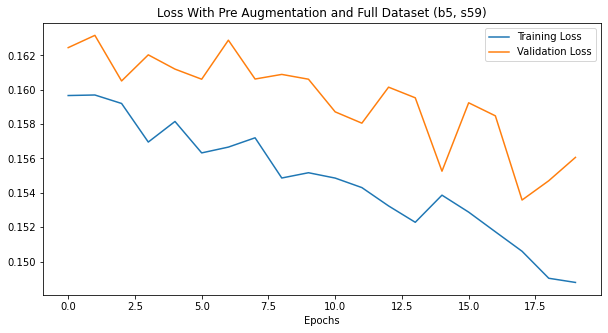

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

plt.figure(figsize=(10,5), facecolor='White')

plt.title("Loss With Pre Augmentation and Full Dataset (b5, s59)")
plt.xlabel("Epochs")
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.legend()
plt.show()

**Fine Tuning the model**

In [ ]:
#unfreezing network

for layer in model.layers[16:]: #16:
    layer.trainable = True
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                           

In [ ]:
opt = keras.optimizers.Adam(learning_rate = 5e-6)
model.compile(optimizer = opt, loss='binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint(save_name, monitor='loss', verbose=1, save_best_only=False)
history = model.fit(
    train_gen, 
    steps_per_epoch=len(train_gen), 
    epochs=10,
    callbacks=[model_checkpoint], 
    validation_data=valid_gen
)

Epoch 1/10
28/28 [==============================] - ETA: 0s - loss: 0.1460 - accuracy: 0.9429
Epoch 1: saving model to unet_grain_nouveaux_transfer_reverse.hdf5
28/28 [==============================] - 18s 576ms/step - loss: 0.1460 - accuracy: 0.9429 - val_loss: 0.1557 - val_accuracy: 0.9430
Epoch 2/10
28/28 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.9429
Epoch 2: saving model to unet_grain_nouveaux_transfer_reverse.hdf5
28/28 [==============================] - 14s 504ms/step - loss: 0.1457 - accuracy: 0.9429 - val_loss: 0.1536 - val_accuracy: 0.9430
Epoch 3/10
28/28 [==============================] - ETA: 0s - loss: 0.1460 - accuracy: 0.9429
Epoch 3: saving model to unet_grain_nouveaux_transfer_reverse.hdf5
28/28 [==============================] - 15s 520ms/step - loss: 0.1460 - accuracy: 0.9429 - val_loss: 0.1511 - val_accuracy: 0.9430
Epoch 4/10
28/28 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.9429
Epoch 4: saving model to un

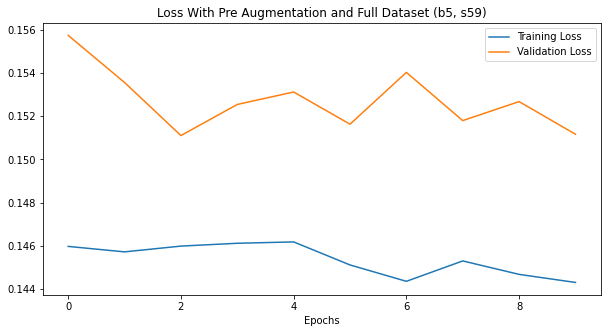

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

plt.figure(figsize=(10,5), facecolor='White')

plt.title("Loss With Pre Augmentation and Full Dataset (b5, s59)")
plt.xlabel("Epochs")
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.legend()
plt.show()